# setup

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import os
import re
import pickle
import random
from typing import Sequence, Tuple
from tempfile import mkdtemp
from datetime import datetime

import optuna
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier, Pool

pd.set_option('display.max_rows', 100)

In [4]:
from src.io import csv_loader_factory, PickleLoader
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder
from src.eval.metrics import compute_metrics

# load raw 

In [5]:
loader = csv_loader_factory('poleval')
data = loader.load()

INFO:2022-01-08 00:06:30:io:loading from csv: ./data/poleval19.csv
INFO:2022-01-08 00:06:30:io:loaded 11039 rows


# base model

## data

In [6]:
train_df = data.loc[data['dataset']=='train', ['text_raw']]
train_label = data.loc[data['dataset']=='train', 'tag']
test_df = data.loc[data['dataset']=='test', ['text_raw']]
test_label = data.loc[data['dataset']=='test', 'tag']

{'clean_email': True,
 'clean_emoji': True,
 'clean_hashtag': True,
 'clean_non_alpha': True,
 'clean_non_letter': True,
 'clean_url': True,
 'clean_user_ref': True,
 'drop_repeated': True,
 'latinize': True,
 'to_lower': True}

In [8]:
# train
train_tokens = pd.Series(map(lambda text: text.split(), train_clean['text_clean']))
train_tokens.index = train_clean.index

train_tokens = train_tokens[(pd.Series(map(len, train_tokens))>0).values]
train_label_tok = train_label[train_tokens.index]


# test
test_tokens = pd.Series(map(lambda text: text.split(), test_clean['text_clean']))
test_tokens.index = test_clean.index

test_tokens = test_tokens[(pd.Series(map(len, test_tokens))>0).values]
test_label_tok = test_label[test_tokens.index]

In [9]:
emb = W2VEmbedder(vector_size=250, sg=1, epochs=5, max_final_vocab=5000)


emb.fit(train_tokens)
train_w2v = emb.transform(train_tokens)
test_w2v = emb.transform(test_tokens)

INFO:2022-01-08 00:06:33:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-08 00:06:33:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-08 00:06:33:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 21734 word types
INFO:2022-01-08 00:06:33:gensim.models.word2vec:collected 21764 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-08 00:06:33:gensim.utils:Word2Vec lifecycle event {'msg': 'max_final_vocab=5000 and min_count=5 resulted in calc_min_count=3, effective_min_count=5', 'datetime': '2022-01-08T00:06:33.719475', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-08 00:06:33:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-08 00:06:33:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min

INFO:2022-01-08 00:06:34:gensim.utils:Word2Vec lifecycle event {'msg': 'training on 525230 raw words (270631 effective words) took 0.5s, 511108 effective words/s', 'datetime': '2022-01-08T00:06:34.314890', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO:2022-01-08 00:06:34:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=2518, vector_size=250, alpha=0.025)', 'datetime': '2022-01-08T00:06:34.314890', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


## model

0:	test: 0.5092011	best: 0.5092011 (0)	total: 193ms	remaining: 3m 13s
10:	test: 0.4886679	best: 0.5128160 (1)	total: 712ms	remaining: 1m 3s
20:	test: 0.5154991	best: 0.5183634 (19)	total: 1.29s	remaining: 1m
30:	test: 0.5351091	best: 0.5380166 (29)	total: 1.79s	remaining: 55.9s
40:	test: 0.5396644	best: 0.5468424 (32)	total: 2.33s	remaining: 54.5s
50:	test: 0.5279570	best: 0.5468424 (32)	total: 2.9s	remaining: 54s
60:	test: 0.5146407	best: 0.5468424 (32)	total: 3.58s	remaining: 55.2s
70:	test: 0.5063756	best: 0.5468424 (32)	total: 4.3s	remaining: 56.3s
80:	test: 0.5105168	best: 0.5468424 (32)	total: 4.94s	remaining: 56.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5468423777
bestIteration = 32

Shrink model to first 33 iterations.


,train,test
AUC,0.615821,0.546842
Accuracy,0.836425,0.818819
F1,0.034158,0.117073
Precision,0.034158,0.169014
Recall,0.034158,0.089552


|mean pred |0.337779|0.337803|


<AxesSubplot:ylabel='Frequency'>

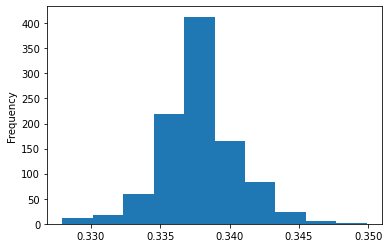

In [10]:
params = {
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 10,
    'grow_policy': 'Depthwise', #'SymmetricTree', 'Depthwise', 'Lossguide'
    'min_data_in_leaf': 10,
    'learning_rate': 0.01,
    'reg_lambda': 5
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

proba_train = cb.predict_proba(train_w2v)[:, 1]
proba_test = cb.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

# optuna res

In [118]:
name = 'test_study_20220108_0154.pkl'
path = os.path.join('./opt_studies/', name)

with open(path, 'rb') as p:
    study = pickle.load(p)

study_df = study.trials_dataframe()
study_df['is_best'] = 0
study_df.loc[[t.number for t in study.best_trials], 'is_best'] = 1

run = len(study_df)
completed = len(study_df[study_df['state']=='COMPLETE'])

print(f'run: {run}, compleated: {completed} ({round(completed/run, 3)})')
study_df[study_df['is_best']==1].sort_values('values_0', ascending=False)

run: 1516, compleated: 1375 (0.907)


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_alpha,params_epochs,params_grow_policy,params_latinize,...,params_ns_exponent,params_num_leaves,params_reg_lambda,params_sg,params_to_lower,params_vector_size,system_attrs_nsga2:generation,system_attrs_nsga2:parents,state,is_best
1250,1250,0.616245,0.028436,2022-01-08 11:58:40.560339,2022-01-08 11:59:06.278594,0 days 00:00:25.718255,0.091,10.0,Lossguide,False,...,0.60,18.0,7.0,1.0,False,100.0,19,"[1002, 709]",COMPLETE,1
398,398,0.599375,0.066667,2022-01-08 09:22:44.769109,2022-01-08 09:23:32.319982,0 days 00:00:47.550873,0.081,5.0,Lossguide,True,...,0.40,24.0,7.0,0.0,False,250.0,5,"[311, 174]",COMPLETE,1
505,505,0.597256,0.111111,2022-01-08 09:40:16.583625,2022-01-08 09:40:51.973959,0 days 00:00:35.390334,0.061,8.0,Lossguide,True,...,0.30,12.0,9.0,1.0,False,250.0,7,"[357, 372]",COMPLETE,1
949,949,0.582098,0.122271,2022-01-08 11:08:28.751767,2022-01-08 11:09:01.042834,0 days 00:00:32.291067,0.061,5.0,Lossguide,True,...,0.90,24.0,7.0,1.0,False,250.0,14,"[659, 829]",COMPLETE,1
546,546,0.576745,0.134529,2022-01-08 09:51:23.325951,2022-01-08 09:52:19.067864,0 days 00:00:55.741913,0.071,9.0,Lossguide,True,...,-0.05,6.0,5.0,0.0,False,750.0,8,"[328, 467]",COMPLETE,1
556,556,0.554620,0.155738,2022-01-08 09:52:28.328678,2022-01-08 09:52:45.362703,0 days 00:00:17.034025,0.101,10.0,Lossguide,False,...,0.40,24.0,5.0,1.0,False,250.0,8,"[206, 454]",COMPLETE,1
1486,1486,0.535899,0.160000,2022-01-08 12:50:00.386456,2022-01-08 12:50:25.723644,0 days 00:00:25.337188,0.051,7.0,Lossguide,True,...,0.85,24.0,3.0,1.0,False,50.0,23,"[433, 425]",COMPLETE,1
328,328,0.520158,0.168224,2022-01-08 08:38:08.263067,2022-01-08 08:38:31.035954,0 days 00:00:22.772887,0.071,9.0,Lossguide,True,...,-0.05,18.0,3.0,1.0,False,100.0,4,"[157, 180]",COMPLETE,1
610,610,0.504063,0.170213,2022-01-08 10:04:03.464676,2022-01-08 10:04:42.311106,0 days 00:00:38.846430,0.101,7.0,Lossguide,False,...,0.40,36.0,7.0,0.0,False,250.0,9,"[206, 593]",COMPLETE,1


<AxesSubplot:xlabel='auc', ylabel='f1'>

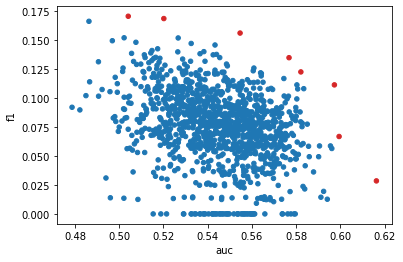

In [114]:
dfp = study_df[study_df['state']=='COMPLETE'][['values_0', 'values_1', 'is_best']].rename({'values_0': 'auc', 'values_1': 'f1'}, axis=1)

color_map ={
    1: 'tab:red',
    0: 'tab:blue'
}
colors = dfp['is_best'].replace(color_map)
dfp.plot.scatter(x='auc', y='f1', c=colors)


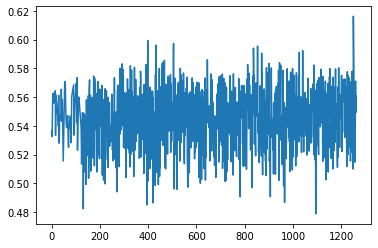

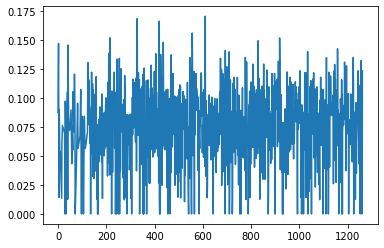

In [98]:
dfp = study_df[study_df['state']=='COMPLETE'][['number', 'values_0', 'values_1']].rename({'values_0': 'auc', 'values_1': 'f1'}, axis=1)

dfp['auc'].plot()
plt.show()
dfp['f1'].plot()
plt.show()

In [103]:
imp_auc = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])
imp_f1 = optuna.importance.get_param_importances(study, target=lambda t: t.values[1])

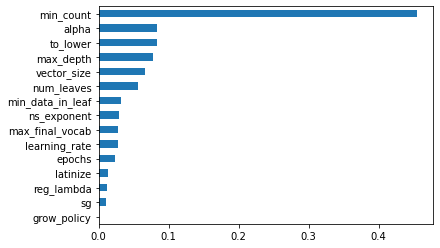

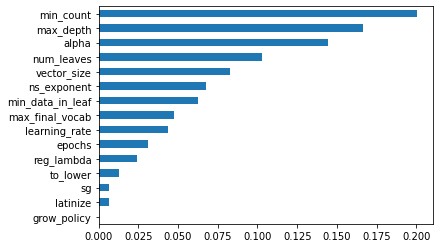

In [111]:
pd.Series(imp_auc).sort_values().plot.barh()
plt.show()

pd.Series(imp_f1).sort_values().plot.barh()
plt.show()

**Insights**:  

Text cleaner
* `params_latinize` minor impact -> can be defaulted to **False**
* `params_to_lower` lowers both **auc** and **f1** -> default to **False**

W2V Encoder
* positive corr of `epochs` with **f1** -> increase max number of `epoch` ~20
* !**auc** and **f1** has almost perfect negative corellation with respect to number of `epoch`
* increase `params_alpha` significant increasing trend of **f1** -> max should be increased to 0.2
* `params_max_final_vocab` should be between 10-15k
* `params_min_count`:  
    * **auc** is maximized in 100-125 range
    * **f1** max around 50-60, negative corr
* `params_ns_exponent` best metric values between -0.2 and 0.2, above 0.2 both metrics decrease
* `params_sg` minor impact on average metrics -> fix at 0
* `params_vector_size`  
Best **auc** values match lowest **f1** values. Similarly in the oher side
    * **auc** best values between 400 and 750
    * **f1** best values between 300 and 600

Learner
* `params_learning_rate` slight increasing trend of **f1** -> max should be increased to 0.2
* ?`params_grow_policy` other than *Lossguide* failed
* `params_max_depth`: negative corr with **auc** and positive with **f1**
Best **auc** at 3, best **f1** at 13
* `params_min_data_in_leaf` both metrics has positive corr -> should be increased to ~200
* `params_num_leaves` significant impact, similar to max_depth
Best **auc** at 5, best **f1** at 35
* `params_reg_lambda` minor impact, should be between 3 and 7, can be fixed to 5/6
Best **auc** at 3, best **f1** at 7

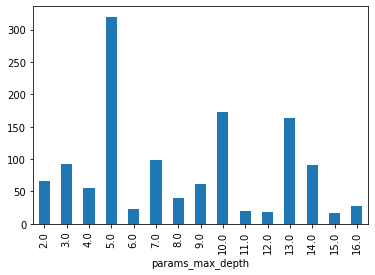

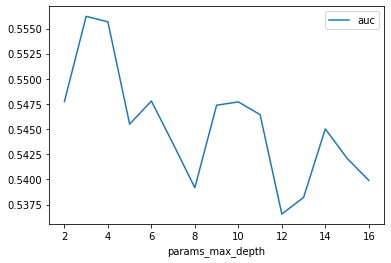

<AxesSubplot:xlabel='params_max_depth'>

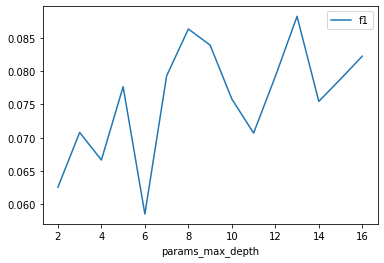

In [112]:
dfg = study_df.groupby('params_max_depth').agg(
    size=('params_grow_policy', 'size'),
    auc=('values_0', 'median'),
    f1=('values_1' ,'median')
)

dfg['size'].plot(kind='bar')
plt.show()
dfg[['auc']].plot()
plt.show()
dfg[['f1']].plot()

In [30]:
study_df[study_df['state']=='COMPLETE'].sort_values('values_0', ascending=False).iloc[1,:]

number                                                  505
values_0                                           0.597256
values_1                                           0.111111
datetime_start                   2022-01-08 09:40:16.583625
datetime_complete                2022-01-08 09:40:51.973959
duration                             0 days 00:00:35.390334
params_alpha                                          0.061
params_epochs                                             8
params_grow_policy                                Lossguide
params_latinize                                        True
params_learning_rate                                  0.046
params_max_depth                                        5.0
params_max_final_vocab                                11600
params_min_count                                        110
params_min_data_in_leaf                                41.0
params_ns_exponent                                      0.3
params_num_leaves                       